In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys


import bcolz
import pandas as pd
import xarray as xr

from floater.generators import FloatSet
from floater import hexgrid
from helper import bcolz_to_array, dataseries_to_array, region_to_json
from tools_lagrangian import rel_disp, calc_l1_l2, calc_flow_map, latlon_2_xy, ddt

from matplotlib.colors import LogNorm

# Lagrangian Diagnostics from llc_offline#

The four key diagnostics used are 

1. Finite time Lyapunov exponents
2. The Histogram of FTLE
3. Timeseries of Relative Dispersion/Diffusivity
4. PDF of Dispersion

The methods used to identify these diagnostics are illustrated below

## Finite time Lyapunov exponents (FTLEs)##

From the flow map $\mathbf{F}$ we calculate the Jacobian as $\nabla \mathbf{F}$. Then the left Cauchy-Green stress tensor C is calculated as 

$$C = {\nabla \mathbf{F}}^T \nabla \mathbf{F}$$

But for us, since we are dealing with a hexagonal grid we also require a Jacobian Transformation matrix $J_T$ s.t.

$$\nabla \mathbf{F} =  {\nabla \mathbf{F}}_{hex} \mathbf{J_T}$$

where ${\nabla \mathbf{F}}_{hex}$ is a $2 \times 3$ matrix and $J_T$ is a $3 \times 2$ matrix, which gives us the effective $\nabla \mathbf{F}$ as a $2 \times 2$ matrix, which is what we require. 
As a result we rewrite our left C-G tensor as

$$C = {\nabla \mathbf{F}}^T \cdot \nabla \mathbf{F} = {{\nabla \mathbf{F}}_{hex} \mathbf{J_T}}^T \cdot {\nabla \mathbf{F}}_{hex} \mathbf{J_T} ={\mathbf{J_T}}^T {{\nabla \mathbf{F}}_{hex}}^T \cdot {\nabla \mathbf{F}}_{hex} \mathbf{J_T}$$

The maximum eigenvalues of this C-G tensor $\lambda_1$ gives the FTLE as follows

$$FTLE = \frac{1}{T}\log (\lambda_1)$$ where $T$ is the time period.

In our examples, the troubling part is the fact that for the histogram (which is the un-normalised PDF) of the FTLE has a huge count at the smallest value. Upon looking closely, the reason for such a behavior is attributed to the fact the even though all $\lambda_1$ values $\leq 1$ are truncated (eliminating all $FTLE=0$, since $\log(1) = 0$), there are many values of $\lambda_1$ which are very close to 1. Ideally what we want is the rest of the figure except the first bin. The question now is what value should we pick to truncate $\lambda_1$ numericallly and what decides that cutoff.

## Relative Dispersion ##

From LaCasce (2008), Keating et al. (2011) and Rypina et al. (2012) :

Mean drift of the center of mass, in the x direction

$$M_x(t) = \frac{1}{N} \sum_{i=1}^{N} \left( x_i(t) - x_i(0)\right)$$

The spread about the center of mass is the variance of displacemets (second order moment), also called the dispersion $D_x(t)$

$$D_x(t) = \frac{1}{N-1} \sum_{i=1}^{N} {\left( x_i(t) - x_i(0) - M_x(t)\right)}^2$$

The Diffusivity is given as 

$$K_x(t) = \frac{1}{2}\frac{d}{dt}\left(D_x(t)\right)$$

Using the above expressions for mean and variance, we can construct an analytic PDF for the dispersion as follows:

$$Q_x = \frac{1}{\sqrt{2 \pi D_x}} e^{\frac{-\left(x_i(t) - x_i(0) - M_x\right)^{-2}}{2 D_x}}$$

In [2]:
dir1 = '/data/scratch/as4479/llc_run_s_2/trajectories_fewer_fields.bcolz/'
dir2 = '/data/scratch/as4479/llc_run_s_3/trajectories_fewer_fields.bcolz/'
dir3 = '/data/scratch/as4479/llc_run_2d_weekly/trajectories_fewer_fields.bcolz/'
dir4 = '/data/scratch/as4479/llc_run_3d_weekly/trajectories_fewer_fields.bcolz/'
dir5 = '/data/scratch/as4479/llc_run_2d_daily/trajectories_fewer_fields.bcolz/'
dir6 = '/data/scratch/as4479/llc_run_3d_daily/trajectories_fewer_fields.bcolz/'

figdir = 'figures_abstract_AOFD/'

#case = ['llc_run2_s_2','llc_run3_s2','llc_run_s_2','llc_run_s_3', 'llc_run3_s3']
case = ['2d_hourly_unf','3d_hourly_unf','2d_weekly_filter','3d_weekly_filter','2d_daily_filter','3d_daily_filter',]
cases = ['2d float, unfiltered','3d float, unfiltered','2d float, 1 week fiter',
         '3d float, 1 week filter','2d float, 1 day fiter','2d float, 1 day fiter']

floatset = FloatSet((-60.,-50.), (33.,40.5), dx = 0.02, dy = 0.015)

bcolz_dir = [dir1, dir2, dir3, dir4, dir5, dir6]

In [ ]:
for i in range(6):
    lamb1, lamb2, mask = calc_l1_l2(bcolz_dir[i], floatset, calc_T_D=True)
    M_x, M_y, D_x, D_y, K_x, K_y, deltax, deltay = rel_disp(bcolz_dir[i])
    
    FTLE = 28.**-1*np.log(lamb1)
    FTLE = np.ma.masked_array(FTLE, mask)
    FTLE_rav = np.ravel(FTLE)
    
    Q_x = (np.sqrt(2*np.pi*D_x.isel(time=-1)))**-1 * np.exp(-((deltax.isel(time=-1)-M_x.isel(time=-1))**2./(2*D_x.isel(time=-1))))
    Q_y = (np.sqrt(2*np.pi*D_y.isel(time=-1)))**-1 * np.exp(-((deltay.isel(time=-1)-M_y.isel(time=-1))**2./(2*D_y.isel(time=-1))))
    
    fig = plt.figure(figsize=(15,20))
    
    plt.subplot(321)
    plt.pcolormesh(FTLE, cmap='hot_r', rasterized=True);
    plt.title(r'FTLE${[day]}^-1$ ', fontsize=13 )
    #plt.clim([0.0,0.5])
    plt.colorbar()
    
    plt.subplot(322)
    plt.hist(FTLE_rav.compressed(), bins=100 );
    plt.xlabel('FTLE')
    #plt.ylabel('Count')
    plt.title('FTLE histogram', fontsize = 13)
    
    plt.subplot(323)
    D_x[0:].plot(label='D_x')
    D_y[0:].plot(label='D_y')
    plt.xlabel('time, $[seconds]$')
    plt.title(r'Relative Dispersion, $D_{rel}$ , $[m^2]$', fontsize=13)
    plt.ylabel(r'$D_{rel}$ , $[m^2]$', fontsize=13)
    #plt.tick_params(left='off')
    plt.legend(loc=0,fontsize='small')
    
    plt.subplot(324)
    K_x[0:].plot(label='K_x')
    K_y[0:].plot(label='K_y')
    plt.xlabel('time, $[seconds]$')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(r'Relative Diffusivity, $K_{rel}$ $[m^2/s]$', fontsize=13)
    #plt.ylabel(r'$K_{rel}$ $[m^2/s]$', fontsize=13)
    plt.legend(loc=0,fontsize='small')

    plt.subplot(325)
    deltax.isel(time=-1).plot.hist(bins=100, normed=True);
    plt.plot(deltax.isel(time=-1), Q_x, 'g+' ,label = 'PDF analytic')
    plt.xlabel(r'$\Delta x$', fontsize=13)
    #plt.tick_params(left='off')

    plt.title(r'$\Delta x$ PDF')
    
    plt.subplot(326)
    deltay.isel(time=-1).plot.hist(bins=100, normed=True);
    plt.plot(deltay.isel(time=-1), Q_y, 'g+' ,label = 'PDF analytic')
    plt.xlabel(r'$\Delta y$', fontsize=13)
    #plt.tick_params(left='off')
    plt.title(r'$\Delta y$ PDF')
    
    plt.legend(loc=0, fontsize='small')
    
    plt.suptitle('%s' %cases[i], fontsize = 16)
    fig.savefig(figdir+'%s.pdf' %case[i])

(-0.001, 0.001)

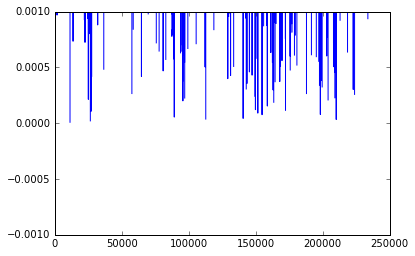

In [63]:
FTLE_rav = np.ravel(FTLE)
plt.plot(FTLE_rav)
plt.ylim([-0.001,0.001])

In [57]:

M_x, M_y, D_x, D_y, K_x, K_y, deltax, deltay = rel_disp(bcolz_dir[i])
X0, Y0, X1, Y1 = calc_flow_map(bcolz_dir[2], floatset) 
lamb1, lamb2, mask = calc_l1_l2(bcolz_dir[2], floatset, calc_T_D=True)
FTLE = len(M_x)**-1*np.log(lamb1)
FTLE = np.ma.masked_array(FTLE, mask)
ftle = xr.DataArray(FTLE, coords = [X0[0],Y0[:,0]], dims=['x', 'y'])
ftle.to_dataset(name = "FTLE").to_netcdf(path='/data/scratch/as4479/FTLE'+'%s.nc' %case[i], format='NETCDF4')

In [41]:
ftle = xr.DataArray(FTLE, coords = [X0[0],Y0[:,0]], dims=['x', 'y'])

In [49]:
ftle2 = ftle.to_dataset(name = "FTLE")

In [54]:
ftle2.to_netcdf(path='/data/scratch/as4479/FTLE'+'%s.nc' %case[i], format='NETCDF4')

In [58]:
deltax

<xarray.DataArray (time: 25, npart: 250000)>
array([[      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [  66257.1640625 ,   65799.5703125 ,   65321.3828125 , ...,
           5831.82958984,    5764.85351562,    5709.17480469],
       [ 107470.671875  ,  105901.109375  ,  104329.6328125 , ...,
          11574.61328125,   11594.28320312,   11594.66503906],
       ..., 
       [ 115659.5390625 ,  100603.9609375 ,   83048.9140625 , ...,
          67822.4765625 ,   66137.40625   ,   64452.33984375],
       [ 125023.109375  ,  113556.        ,   93357.078125  , ...,
          67822.4765625 ,   66137.40625   ,   64452.33984375],
       [ 135717.203125  ,  122031.25      ,  104953.265625  , ...,
          67822.4765625 ,   66137.40625   ,   64452.33984375]], dtype=float32)
Coordinates:
  * time     (time) float64 0.0 8.64e+04 1.728e+05 2.592e+05 3.456e+05 ...
  * npart    (npart) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8

In [61]:
ds = xr.Dataset({'deltax': (['time', 'npart'],  deltax),
                  'deltay': (['time', 'npart'],  deltay)},
                {'D_x': (['time'],  D_x),
                 'D_y': (['time'],  D_y),
                 'M_x': (['time'],  M_x),
                 'M_y': (['time'],  M_y)}
               )


ValueError: conflicting sizes for dimension 'time': length 24 on 'K_y' and length 25 on 'deltax'

In [60]:
ds

<xarray.Dataset>
Dimensions:  (npart: 250000, time: 25)
Coordinates:
    D_x      (time) float32 0.0 2.52232e+08 9.78913e+08 2.08454e+09 ...
    D_y      (time) float32 0.0 2.29969e+08 8.55614e+08 1.72926e+09 ...
  * npart    (npart) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    deltax   (time, npart) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    deltay   (time, npart) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...